In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
plot_config.set_config()

In [2]:
experiment = 'powersupply_ninc'
t_importance = load('../data/'+experiment+'/importance.joblib')
t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-15:]
importance = [k for k,v in dic]
fname = [v for k,v in dic]
pos = np.arange(len(importance))

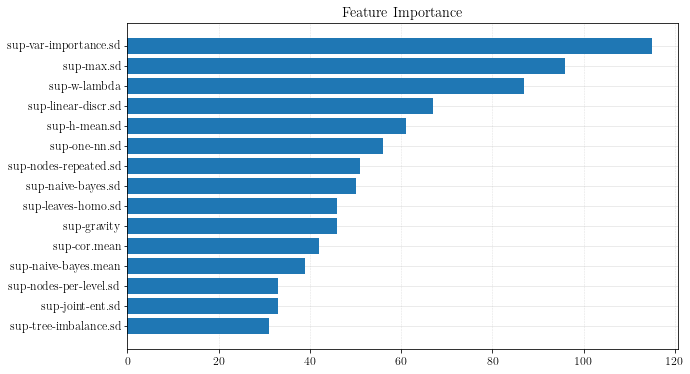

In [3]:
fig, ax1 = plt.subplots(figsize=(10,6))
fig.subplots_adjust(left=0.115, right=0.88)
ax1.set_title('Feature Importance')
ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
rects = plt.barh(pos, importance,
         align='center',
         tick_label=[x.replace('_','-') for x in fname])
plt.savefig(experiment+'_fi.pdf', bbox_inches='tight')

In [4]:
arange = 1000
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
cum = np.cumsum(difference)[:arange]
x = np.arange(arange)

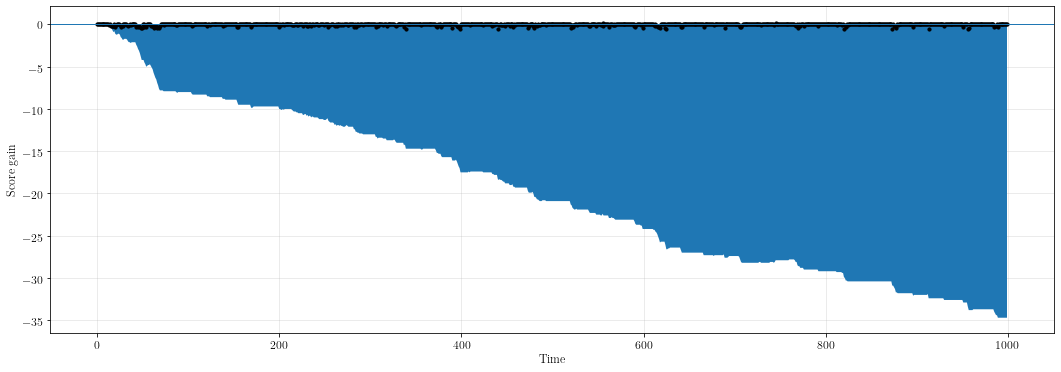

In [5]:
plt.figure(figsize=(18, 6))
plt.fill_between(x, cum, 0)
plt.scatter(x, difference[:arange], s=10, c='black')
plt.axhline(0)
plt.xlabel('Time')
plt.ylabel('Score gain')
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [6]:
print(cum[-10:])

[-34.7 -34.7 -34.7 -34.7 -34.7 -34.7 -34.7 -34.7 -34.7 -34.7]


In [7]:
with open('../'+experiment.replace('_','-')+'.output') as fin:
    print(fin.read())

[FINETUNING BASE MODELS]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	RandomForestClassifier   0.650
	LinearSVC                0.350
[OFFLINE LEARNING]
Kappa:    0.247
GMean:    0.576
Accuracy: 0.680
[[ 42  63]
 [ 33 162]]
              precision    recall  f1-score   support

           0       0.56      0.40      0.47       105
           1       0.72      0.83      0.77       195

    accuracy                           0.68       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.66      0.68      0.66       300

                   pre       rec       spe        f1       geo       iba       sup

          0       0.56      0.40      0.83      0.47      0.58      0.32       105
          1       0.72      0.83      0.40      0.77      0.58      0.35       195

avg / total       0.66      0.68      0.55      0.66      0.58      0.34       300

[ONLINE LEARNING]
Kappa:  0.17873332631488648
GMean:  0.5775930789266092
Accuracy:  0.621929298981426


In [8]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))

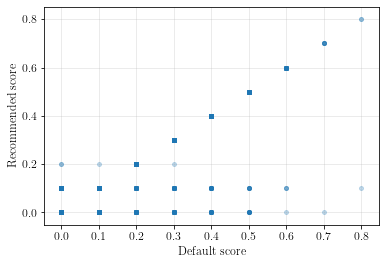

In [9]:
plt.scatter(score_default, score_recommended, alpha=.25)
plt.ylabel('Recommended score')
plt.xlabel('Default score')
plt.savefig(experiment+'_score.pdf', bbox_inches='tight')

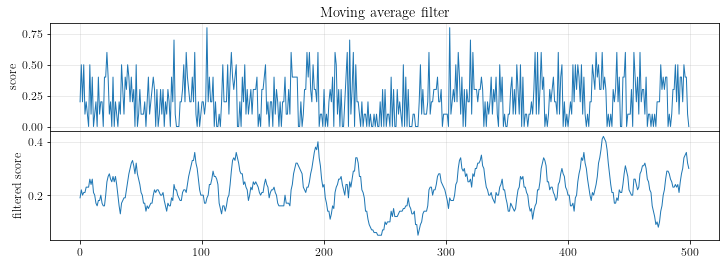

In [10]:
window_score = 500
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})
ax1.plot(score_default[-window_score:])
moving_avg = np.convolve(score_default[-(window_score+N-1):], np.ones((N,))/N, mode='valid')
ax2.plot(moving_avg)
ax1.set_title('Moving average filter')
ax1.set_ylabel('score')
ax2.set_ylabel('filtered score')
plt.savefig(experiment+'_smovingavg.pdf', bbox_inches='tight')

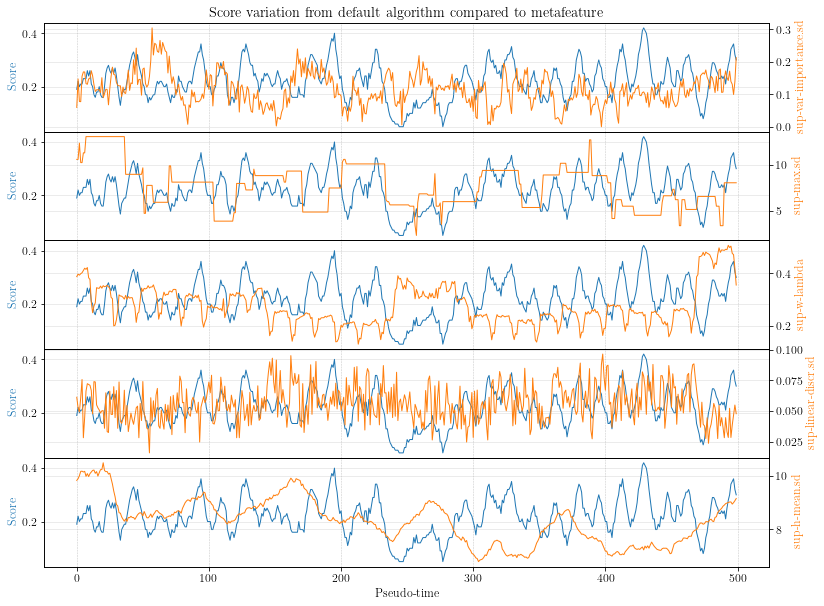

In [11]:
fig, ax = plt.subplots(n_feats, figsize=(13,10), sharex=True, gridspec_kw={'hspace': 0})
for idx,i in enumerate(sorted_feats[:n_feats]):
    ax1 = ax[idx]
    if idx == 0:
        ax1.set_title("Score variation from default algorithm compared to metafeature")
    if idx == n_feats-1:
        ax1.set_xlabel("Pseudo-time")
    ax1.xaxis.grid(linestyle='--', alpha=.75)
    ax1.plot(moving_avg, color='C0')
    ax1.set_ylabel("Score", color='C0')
    ax2 = ax1.twinx()
    ax2.plot(metadf[-window_score:,i], color='C1')
    ax2.set_ylabel("{}".format(t_fname[i].replace('_','-')), color='C1')
plt.savefig(experiment+'_scorexfeat.pdf', bbox_inches='tight')

In [12]:
len(moving_avg)

500

In [13]:
df = pd.DataFrame(metadf[-window_score:], columns=t_fname)
df.rename(columns={x:x.replace('_','-') for x in t_fname}, inplace=True)
df['score-default'] = moving_avg

In [14]:
sel_cols = [x.replace('_','-') for x in list(t_fname[sorted_feats][:4].values)]+['score-default']

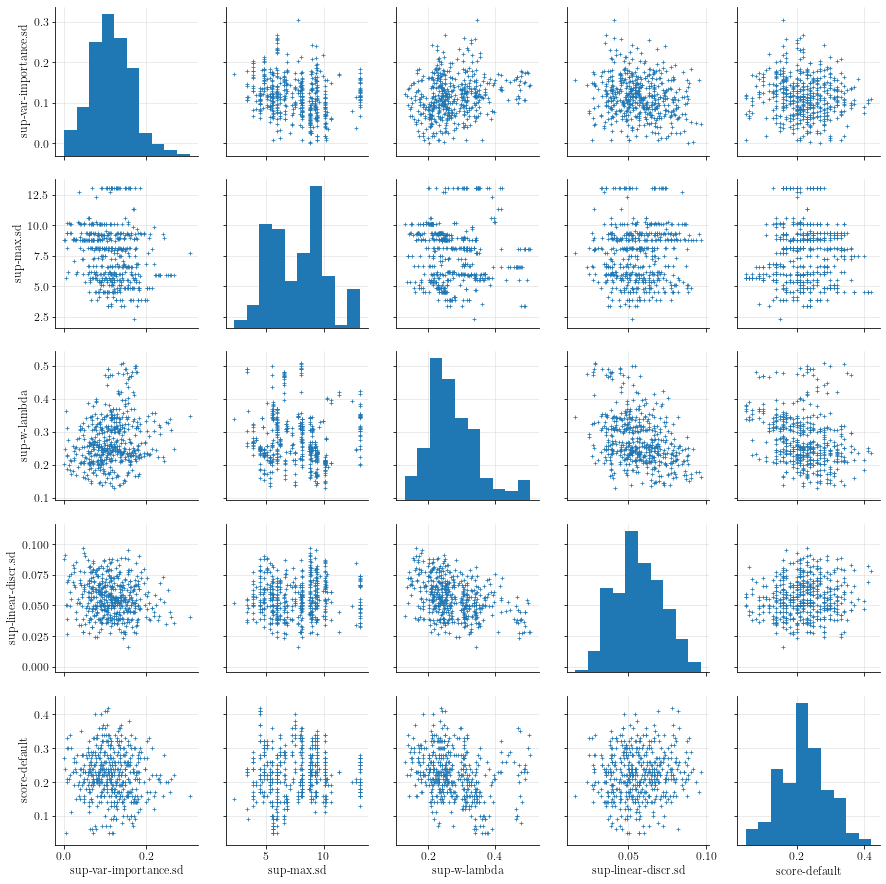

In [15]:
g = sns.pairplot(df.loc[-window_score:,sel_cols], markers="+")
plt.savefig(experiment+'_corr.pdf', bbox_inches='tight')

In [16]:
model = sm.OLS(df['score-default'], df.drop(columns=['score-default']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          score-default   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     11.92
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           1.08e-69
Time:                        00:55:07   Log-Likelihood:                 927.50
No. Observations:                 500   AIC:                            -1689.
Df Residuals:                     417   BIC:                            -1339.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sup-attr-conc.mean    

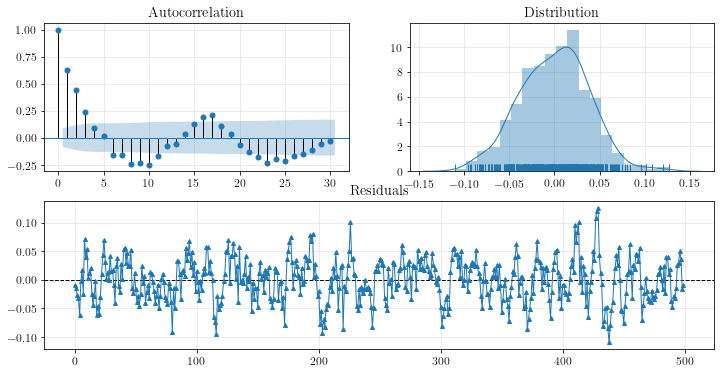

In [17]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(212)
ax1.set_title('Residuals')
ax1.axhline(0, linestyle='--', color='k')
ax1.plot(results.resid, '^-')
ax2 = plt.subplot(221)
sm.graphics.tsa.plot_acf(results.resid, ax=ax2, lags=30)
ax3 = plt.subplot(222)
ax3.set_title('Distribution')
sns.distplot(results.resid, rug=True, ax=ax3)
plt.savefig(experiment+'_residual.pdf', bbox_inches='tight')

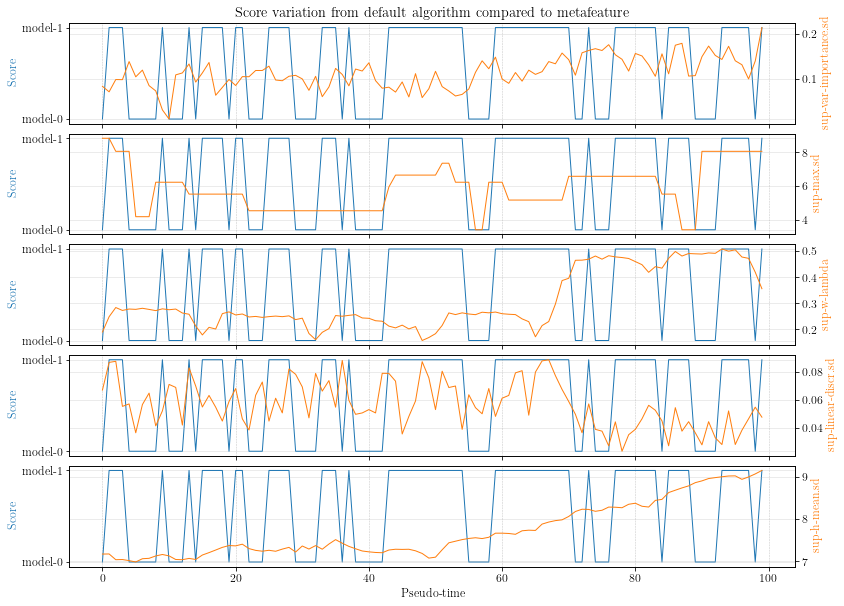

In [18]:
window_score = 100
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
best_model = ['model-{}'.format(x) for x in best[:window_score]]
fig, ax = plt.subplots(n_feats, figsize=(13,10), sharex=True,gridspec_kw={'hspace': 0.1})
for idx,i in enumerate(sorted_feats[:n_feats]):
    ax1 = ax[idx]
    if idx == 0:
        ax1.set_title("Score variation from default algorithm compared to metafeature")
    if idx == n_feats-1:
        ax1.set_xlabel("Pseudo-time")
    ax1.xaxis.grid(linestyle='--', alpha=.75)
    ax1.plot(best_model, color='C0')
    ax1.set_ylabel("Score", color='C0')
    ax2 = ax1.twinx()
    ax2.plot(metadf[-window_score:,i], color='C1')
    ax2.set_ylabel("{}".format(t_fname[i].replace('_','-')), color='C1')
plt.savefig(experiment+'_featxmodel.pdf', bbox_inches='tight')